# Practice sessions - Course 1 and Course 3  
## CART Trees and Random Forests - Jean‐Michel POGGI  
### Master 2 Course in Statistics  
### Universidad de la República – Facultad de Ingeniería, Montevideo, Uruguay
### February 2018 

#### Guide for the practice sessions with the companion scenario, the documentation [cran.r-project.org/web/packages/VSURF/index.html](cran.r-project.org/web/packages/VSURF/index.html) and the two articles: [journal.r-project.org/archive/2015-2/genuer-poggi-tuleaumalot.pdf](journal.r-project.org/archive/2015-2/genuer-poggi-tuleaumalot.pdf) [hal-descartes.archives-ouvertes.fr/hal-01387654v2](hal-descartes.archives-ouvertes.fr/hal-01387654v2)

---

> - **Student:** Guzmán López Orrego
>
> - **Contact:** guzilop@gmail.com

---

## 1. Data

### 1.1. Load the library **kernlab**

> The [**kernlab**](https://cran.r-project.org/web/packages/kernlab/kernlab.pdf 'kernlab pdf manual') library in `R` will be used only to load the **spam** dataset.

In [1]:
# Load library
library(kernlab)

### 1.2. Load the dataset **spam** in R and build the dataframes of learning and test sets (the first will be used for designing trees, the second for evaluating errors)

- #### Explore the **spam** dataset

In [2]:
# Load data
data(spam)

In [3]:
# Explore the spam dataset
?spam

spam {kernlab},R Documentation


In [4]:
# See the spam dataset structure
str(spam)

'data.frame':	4601 obs. of  58 variables:
 $ make             : num  0 0.21 0.06 0 0 0 0 0 0.15 0.06 ...
 $ address          : num  0.64 0.28 0 0 0 0 0 0 0 0.12 ...
 $ all              : num  0.64 0.5 0.71 0 0 0 0 0 0.46 0.77 ...
 $ num3d            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ our              : num  0.32 0.14 1.23 0.63 0.63 1.85 1.92 1.88 0.61 0.19 ...
 $ over             : num  0 0.28 0.19 0 0 0 0 0 0 0.32 ...
 $ remove           : num  0 0.21 0.19 0.31 0.31 0 0 0 0.3 0.38 ...
 $ internet         : num  0 0.07 0.12 0.63 0.63 1.85 0 1.88 0 0 ...
 $ order            : num  0 0 0.64 0.31 0.31 0 0 0 0.92 0.06 ...
 $ mail             : num  0 0.94 0.25 0.63 0.63 0 0.64 0 0.76 0 ...
 $ receive          : num  0 0.21 0.38 0.31 0.31 0 0.96 0 0.76 0 ...
 $ will             : num  0.64 0.79 0.45 0.31 0.31 0 1.28 0 0.92 0.64 ...
 $ people           : num  0 0.65 0.12 0.31 0.31 0 0 0 0 0.25 ...
 $ report           : num  0 0.21 0 0 0 0 0 0 0 0 ...
 $ addresses        : num  0 0.14 1.75 0 0

> To continue exploring the **spam** dataset, the **tidyverse** and the **ggridges** libraries will be loaded into the `R` environment. They will be used to manipulate and visualize data. 

In [5]:
library(tidyverse)
library(ggridges)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.8.0          ✔ stringr 1.3.0     
✔ readr   1.1.1          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::alpha() masks kernlab::alpha()
✖ purrr::cross()   masks kernlab::cross()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()


> Establish manual colors from Monokai palette to use in plots and as a general color theme.

In [6]:
lightgray <- "#75715E"
gray <- "#4D4D4D"
darkgray <- "#272822"
red <- "#C72259"
orange <- "#C97C16"
green <- "#81B023"
purple <- "#8F66CC"
blue <- "#53A8BD"

- #### Create boxplots of variables

> Create the function called `boxplotOfSpamVars` to build boxplots of any variable/s selected from the spam dataset

In [7]:
boxplotOfSpamVars <- function(vars) {
    
    # Reshape the spam data to make a boxplot 
    spam.gather <- spam %>% select(c("type", vars)) %>% gather(key = "var", value = "values", -type)

    # Create a boxplot of every variable separeted by the variable type (spam and nonspam)
    spam.boxplot <- ggplot() + 
    geom_boxplot(data = spam.gather, aes(x = var, y = values, color = type), lwd = 0.25, alpha = 0.5) + 
    scale_color_manual(values = c(green, red), name = "type")
    
    # Create faceting
    spam.boxplot + facet_grid(var ~ ., scales = "free")
}


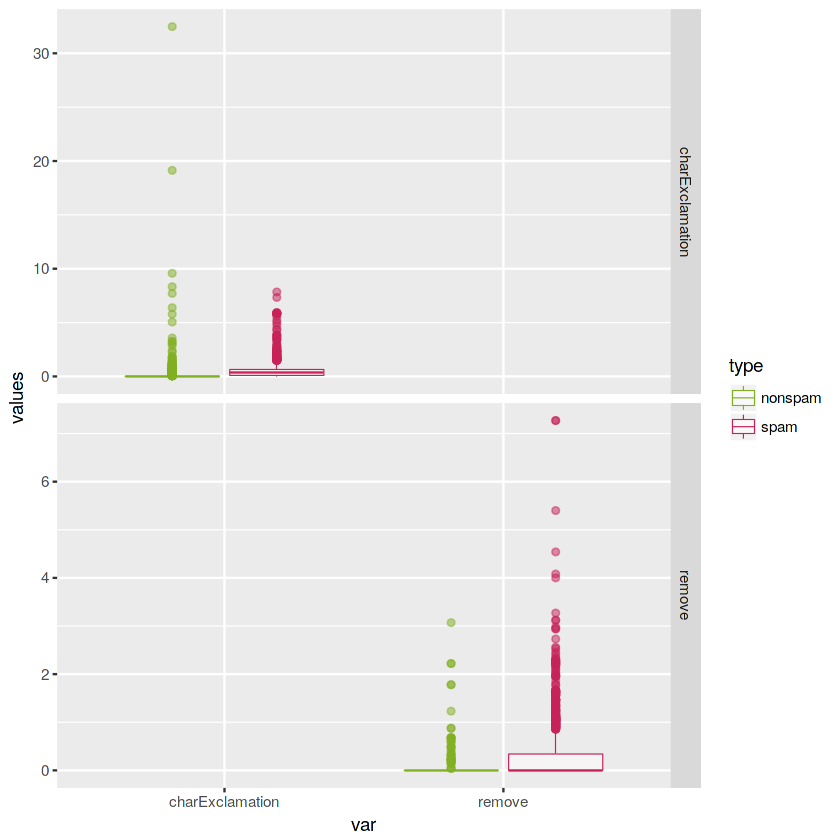

In [8]:
# Explore charExclamation and remove variables
boxplotOfSpamVars(vars = c("charExclamation", "remove"))

> It seems that the character exclamation symbol (*charExclamation*) is more frequent in *spam* mails than in *nonspam* mails. Also, the behaviour is the same for the presence of the word *remove*.

- #### Create density plots of standarized variables to compare their distributions. 1) Center variables by subtracting their means (omitting NAs). 2) Divide the centered variables by their standard deviations.

In [9]:
# Standardization of all the predictor variables
spam.norm <- as.data.frame(scale(spam[, -58]))
spam.norm$type <- spam$type

In [10]:
# Manipulate the standarized spam.norm data to allow making a density plot of all the variables 
spam.norm.gather <- spam.norm %>% 
                        gather(key = "var", value = "values", -type) %>%  # reshape
                            group_by(var, type) %>% # group by columns 'var' and 'type'
                                mutate(median = median(values, na.rm = TRUE)) %>% # calculate medians 
                                    arrange(median) # sort data by median values

# Pint the first 6 rows of the new manipulated data.frame
head(spam.norm.gather)

type,var,values,median
nonspam,your,-0.6743457,-0.6743457
nonspam,your,0.7413656,-0.6743457
nonspam,your,-0.6743457,-0.6743457
nonspam,your,-0.6743457,-0.6743457
nonspam,your,-0.6743457,-0.6743457
nonspam,your,-0.6743457,-0.6743457


Picking joint bandwidth of 0.0332
Warning message:
“Removed 15243 rows containing non-finite values (stat_density_ridges).”

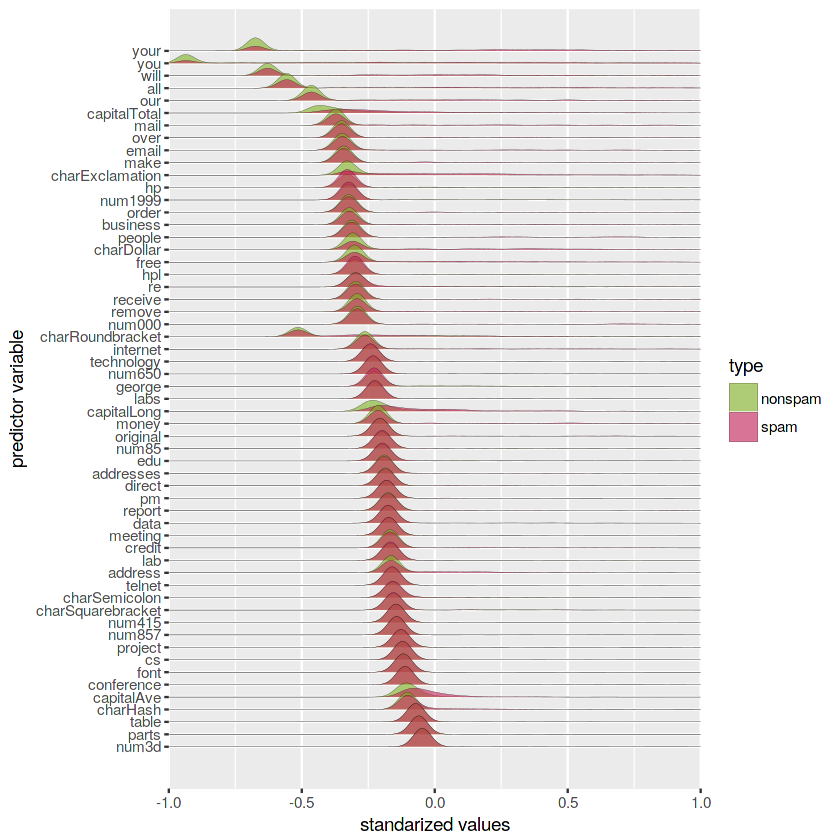

In [11]:
# Create a ggplot of standarized variables densities
ggplot(spam.norm.gather) +
    geom_density_ridges(aes(x = values, 
                            y = factor(as.character(spam.norm.gather$var), levels = rev(unique(as.character(spam.norm.gather$var)))), 
                            fill = type), alpha = 0.6, lwd = 0.05, scale = 1.5) + 
    scale_y_discrete(name = "predictor variable", expand = c(0.06, 0)) + 
    scale_x_continuous(name = "standarized values", expand = c(0, 0), limits = c(-1, 1)) + 
    scale_fill_manual(values = c(green, red), name = "type")

> Comments

- #### Build dataframes by sampling

In [32]:
# Set seed
set.seed(20)

# Add id column to spam data.frame
spam$ID <- 1:nrow(spam)

# Train data.frame
train <- spam %>% sample_frac(size = 0.70, replace = FALSE) # 70% of data for train

# Test data.frame
test <- spam[-train$ID, ] # 30% of the data for test

# Remove ID column
spam <- spam[, -59]
train <- train[, -59]
test <- test[, -59]

> The learn dataset is the object named `train` dataset

## 2. CART trees

### 2.1. Load the library **rpart**

In [13]:
library(rpart)

> The [**rpart**](https://cran.r-project.org/web/packages/rpart/rpart.pdf 'rpart pdf manual') is an `R` library for "Recursive partitioning for classification, regression and survival trees. It is an implementation of most of the functionality of the 1984 book by Breiman, Friedman, Olshen and Stone. It also includes similar Fortran code in the source."

### 2.2. Compute the default tree provided by **rpart**

In [41]:
# Default rpart tree with train data
fit.train.def <- rpart(type ~ ., data = train)

> Plot the default tree using the library [**rpart.plot**](http://www.milbo.org/rpart-plot/prp.pdf) for better tree visualization.

In [42]:
# Load library
library("rpart.plot")

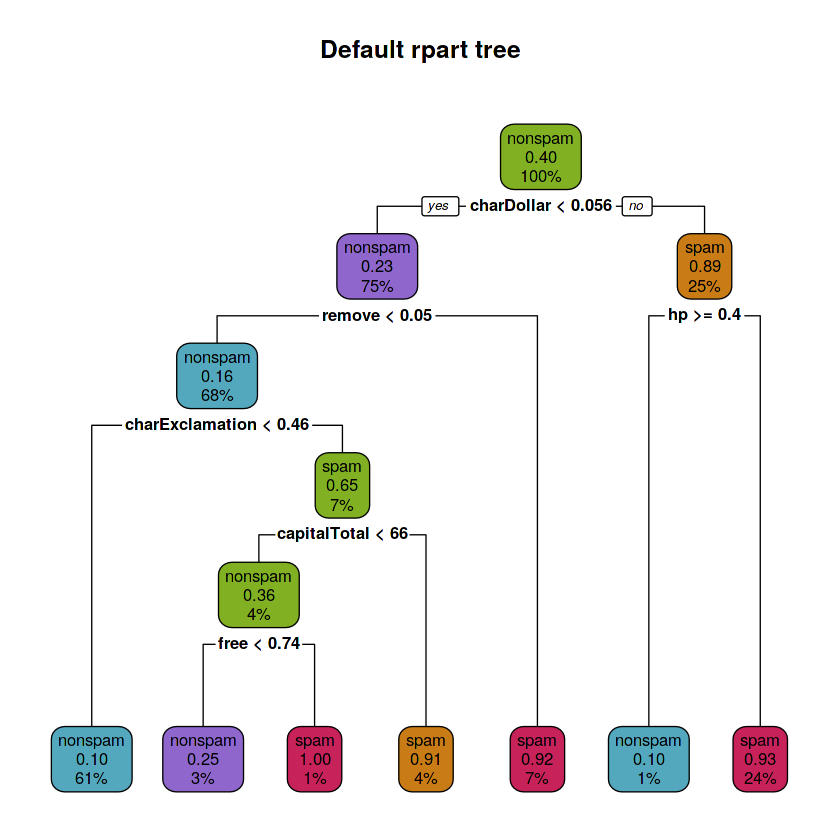

In [43]:
# Plot tree
rpart.plot(fit.train.def, main = "Default rpart tree", box.palette = rev(c(red, orange, green, purple, blue)), type = 2)

Each node of the binary model tree shows:

- the predicted class (*spam* or *nonspam*)
- the predicted probability of *spam*
- the percentage of observations in the node

> The default `rpart` tree has a depth of 5, it has 7 leaves and the splits involve 6 variables: *charDollar*, *remove*, *hp*, *charExclamation*, *capitalTotal* and *free*.
> A high frequency of dollar sign characters, *hp* word, *remove* word, exclamation sign character, *free* word and capital letters present in an e-mail means that is probably a spam e-mail.

### 2.3. Build a tree of depth 1 (stump) and draw it

In [44]:
# Build tree
fit.train.d1 <- rpart(type ~ ., data = train, control = rpart.control(maxdepth = 1))

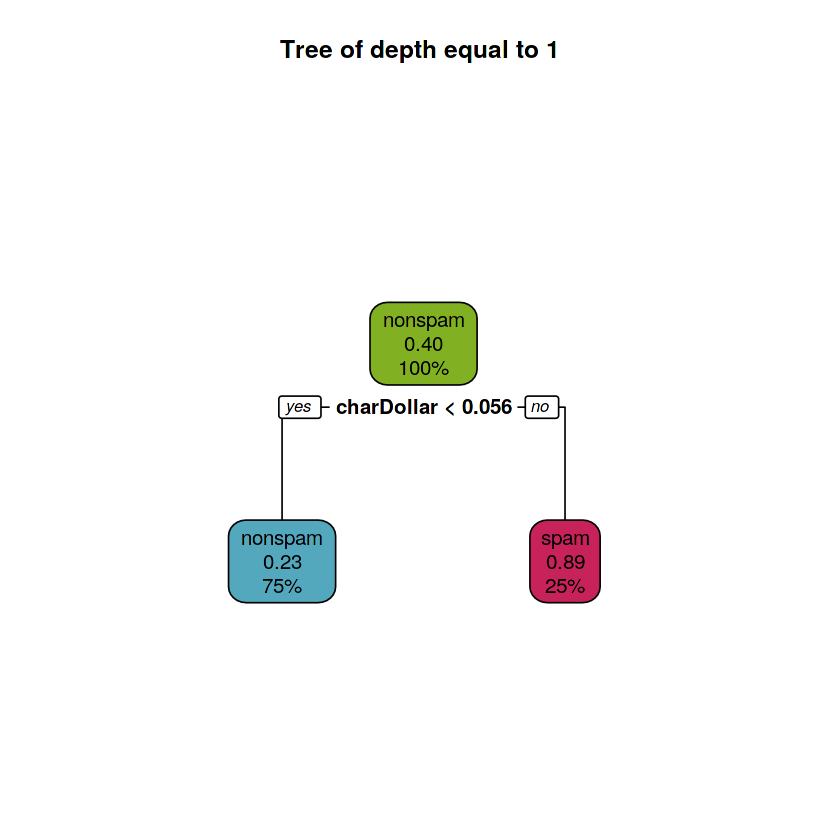

In [46]:
# Plot tree
rpart.plot(fit.train.d1, main = "Tree of depth equal to 1", box.palette = rev(c(red, orange, green, purple, blue)), type = 2)

> The tree of depth equal to 1 has 2 leaves and the split involve 1 variable: *charDollar*.
> Many dollar sign characters present in an e-mail means that is probably (*p = 0.89*) a spam e-mail.

### 2.4. Examine splits: primary splits and surrogate splits

> Once a splitting variable and a split point for it have been decided, the observations that have missing data for this variable are estimated using the other predictor variables. `rpart` uses a variation of this to define surrogate variables.

In [67]:
# Get summary of the rpart model tree
summary(fit.train.d1)

# Also: fit.train.d1$splits

Call:
rpart(formula = type ~ ., data = train, control = rpart.control(maxdepth = 1))
  n= 3221 

         CP nsplit rel error    xerror       xstd
1 0.4913928      0 1.0000000 1.0000000 0.02172579
2 0.0100000      1 0.5086072 0.5367762 0.01818130

Variable importance
 charDollar      num000       money capitalLong      credit       order 
         46          16          16           8           8           7 

Node number 1: 3221 observations,    complexity param=0.4913928
  predicted class=nonspam  expected loss=0.3967712  P(node) =1
    class counts:  1943  1278
   probabilities: 0.603 0.397 
  left son=2 (2417 obs) right son=3 (804 obs)
  Primary splits:
      charDollar      < 0.0555 to the left,  improve=522.4686, (0 missing)
      charExclamation < 0.0525 to the left,  improve=512.7627, (0 missing)
      remove          < 0.01   to the left,  improve=427.5583, (0 missing)
      your            < 0.375  to the left,  improve=407.3059, (0 missing)
      free            < 0.095  to

> The **primary splits** for the node number 1 are: *charDollar*, *charExclamation*, *remove*, *your* and *free* and the **surrogate splits** are: *num000*, *money*, *capitalLong*, *credit* and *order*. There aren't missing data in the primary splits so the surrogate splits weren't used and they don't have any split. There are five primary splits and five surrogate splits retained because those are the default values for `rpart` (*maxsurrogate = 5* and *usesurrogate = 2*).

> Only as a practical example: if we add 10 missing values (`NAs`) to the first primary split variable (*charDollar*) and 5 missing values (`NAs`) to the first surrogate split variable (*num000*) where *charDollar* is `NA`, `rpart` will try to classify the missing values found in *charDollar* using the surrogate splits. `rpart` will use the first surrogate split *num000* for those values where *num000* has no missing values. For those that have missing values (in *charDollar* and also in *num000*) `rpart` will use the second surrogate split *money* to classify those observations.

In [60]:
# Practical example

# Modify train data adding NA values to the first primary split variable (charDollar) and the first surrogate split variable (num000)
train2 <- train

# Add 10 NAs in a random cell position to charDollar variable
train2$charDollar[sample(1:nrow(train), size = 10)] <- NA

# Add 5 NAs in a random cell position to num000 variable but for the 10 possible cells where charDollar is also NA
train2$num000[sample(which(is.na(train2$charDollar)), size = 5)] <- NA

# Build tree
fit.train.d2 <- rpart(type ~ ., data = train2, control = rpart.control(maxdepth = 1))

# Get summary of the rpart model tree
summary(fit.train.d2)

Call:
rpart(formula = type ~ ., data = train2, control = rpart.control(maxdepth = 1))
  n= 3221 

         CP nsplit rel error    xerror       xstd
1 0.4898279      0 1.0000000 1.0000000 0.02172579
2 0.0100000      1 0.5101721 0.5336463 0.01814251

Variable importance
 charDollar      num000       money capitalLong      credit       order 
         46          16          16           8           7           7 

Node number 1: 3221 observations,    complexity param=0.4898279
  predicted class=nonspam  expected loss=0.3967712  P(node) =1
    class counts:  1943  1278
   probabilities: 0.603 0.397 
  left son=2 (2419 obs) right son=3 (802 obs)
  Primary splits:
      charDollar      < 0.0555 to the left,  improve=519.0700, (10 missing)
      charExclamation < 0.0525 to the left,  improve=512.7627, (0 missing)
      remove          < 0.01   to the left,  improve=427.5583, (0 missing)
      your            < 0.375  to the left,  improve=407.3059, (0 missing)
      free            < 0.095  

### 2.5. Build a maximal tree and draw it

In [69]:
# Build tree
fit.train.max <- rpart(type ~ ., data = train, control = rpart.control(cp = 0, minsplit = 1))

Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”

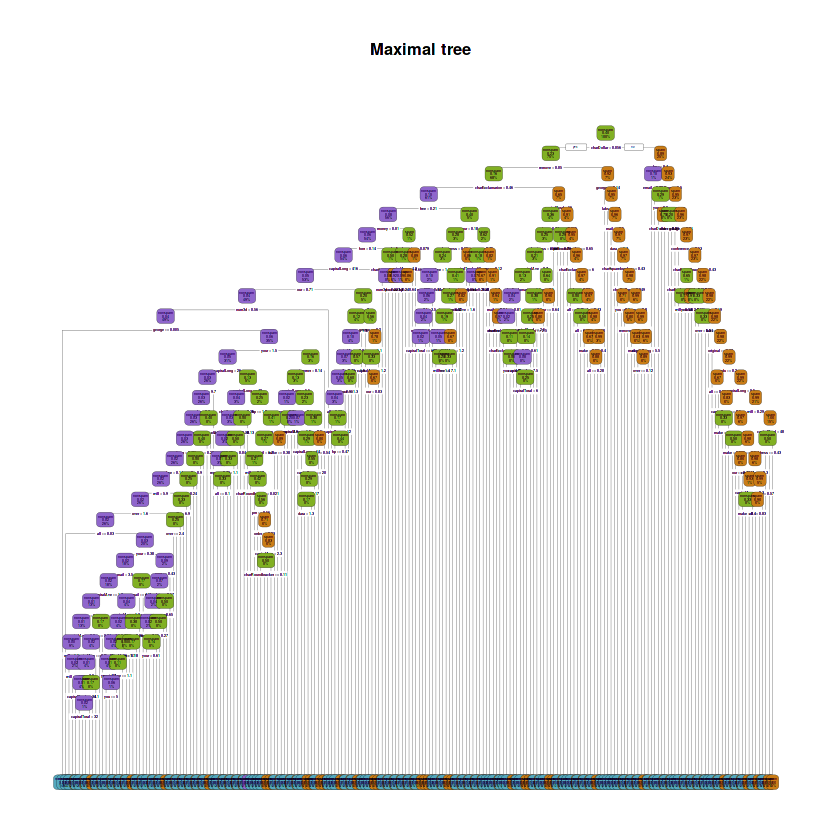

In [70]:
# Plot tree
rpart.plot(fit.train.max, main = "Maximal tree", box.palette = rev(c(red, orange, green, purple, blue)), type = 2)

In [128]:
# rpart::printcp(fit.train.max)

In [69]:
#summary(fit.train.max)

> The maximal tree has a depth of 29, it has xxx leaves and the splits involve 7 variables: *charExclamation*, *remove*, *capitalAve*, *money*, *hp*, *free* and *business*. 
> Many exclamation characters, high average of capital letters and high frecuency of *hp* word present in an e-mail means that is probably a spam e-mail. On the other hand, low number of exclamation characters, low frecuency of the words *remove* and *money* in an e-mail means that is probably a nonspam e-mail.

### 2.6. Draw the OOB errors of the Breiman’s sequence of the pruned subtrees of the maximal tree and interpret it

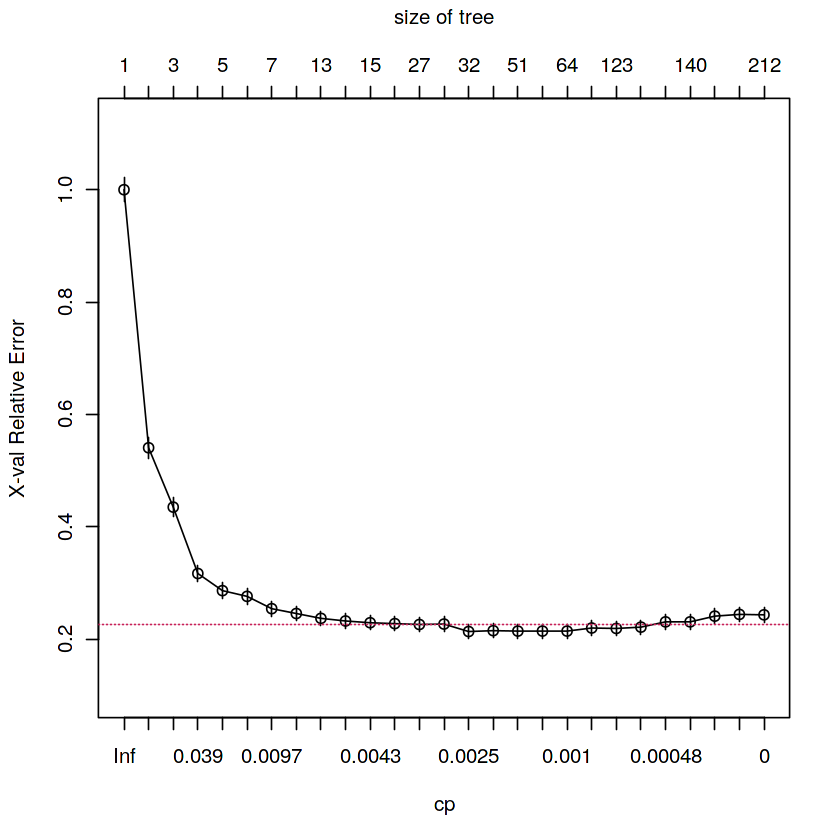

In [71]:
# Plot a Complexity Parameter Table for an Rpart Fit 
plotcp(fit.train.max, col = red)

In [96]:
printcp(fit.train.def)


Classification tree:
rpart(formula = type ~ ., data = train)

Variables actually used in tree construction:
[1] capitalTotal    charDollar      charExclamation free           
[5] hp              remove         

Root node error: 1278/3221 = 0.39677

n= 3221 

        CP nsplit rel error  xerror     xstd
1 0.491393      0   1.00000 1.00000 0.021726
2 0.148670      1   0.50861 0.53912 0.018210
3 0.057903      2   0.35994 0.43271 0.016747
4 0.025822      3   0.30203 0.31768 0.014739
5 0.024257      4   0.27621 0.29812 0.014342
6 0.013302      5   0.25196 0.28169 0.013992
7 0.010000      6   0.23865 0.26213 0.013556


### 2.7. Find the best of them in the sense of an estimate given by the cross-validation prediction error

In [121]:
fit.train.best.cv.cp <- fit.train.max$cptable[which.min(fit.train.max$cptable[, "xerror"]), "CP"]
fit.train.pruned.cv <- prune(fit.train.max, cp = fit.train.best.cv.cp)

### 2.8. Compare the default tree of rpart with the one obtained by minimizing the prediction error. Same question with the one obtained by applying the 1 SE rule

In [120]:
# xerror < min(xerror) + xstd
level.1se <- (which(fit.train.max$cptable[, "xerror"] < min(fit.train.max$cptable[, "xerror"]) + fit.train.max$cptable[, "xstd"]))[1]

fit.train.best.1se.cp <- fit.train.max$cptable[level.1se, "CP"]
fit.train.pruned.1se <- prune(fit.train.max, cp = fit.train.best.1se.cp)

Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”

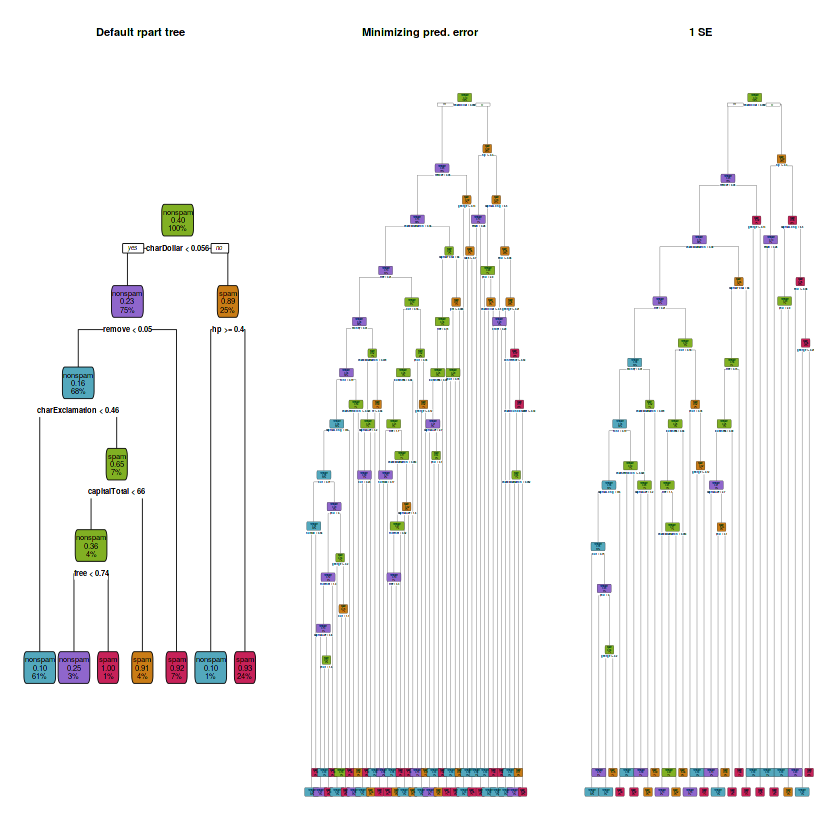

In [122]:
par(mfrow = c(1, 3))
rpart.plot(fit.train.def, main = "Default rpart tree", box.palette = rev(c(red, orange, green, purple, blue)), type = 2)
rpart.plot(fit.train.pruned.cv, main = "Minimizing pred. error", box.palette = rev(c(red, orange, green, purple, blue)), type = 2)
rpart.plot(fit.train.pruned.1se, main = "1 SE", box.palette = rev(c(red, orange, green, purple, blue)), type = 2)
par(mfrow = c(1, 1))

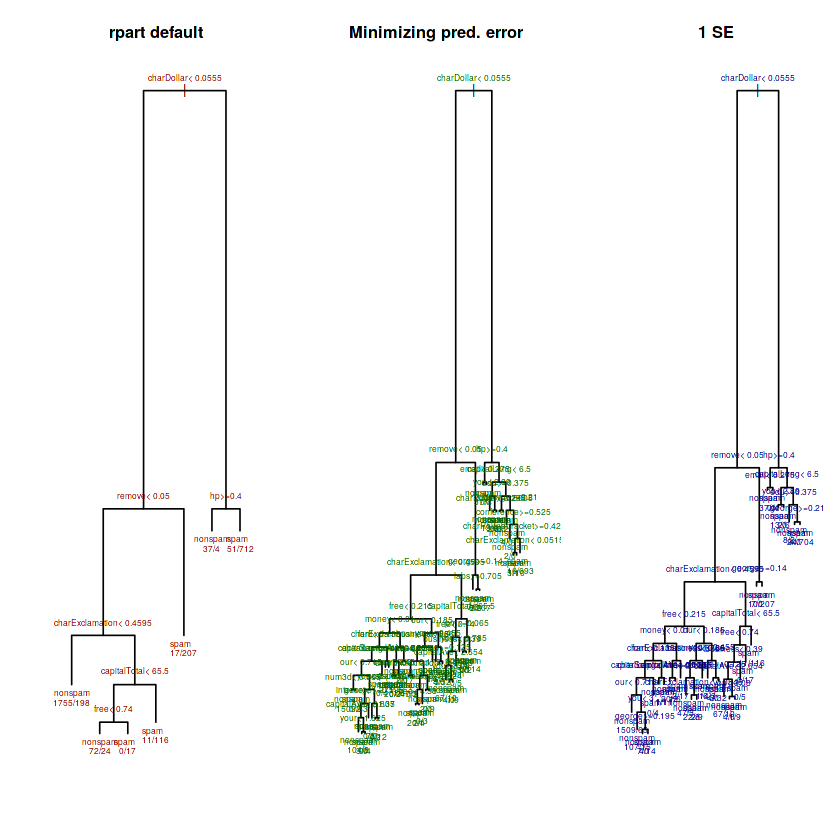

In [123]:
par(mfrow = c(1, 3))

plot(fit.train.def, uniform = FALSE, main = "rpart default")
text(fit.train.def, cex = 0.6, use.n = TRUE, xpd = TRUE, col = "darkred")

plot(fit.train.pruned.cv, uniform = FALSE, main = "Minimizing pred. error")
text(fit.train.pruned.cv, cex = 0.6, use.n = TRUE, xpd = TRUE, col = "darkgreen")

plot(fit.train.pruned.1se, uniform = FALSE, main = "1 SE")
text(fit.train.pruned.1se, cex = 0.6, use.n = TRUE, xpd = TRUE, col = "darkblue")

par(mfrow = c(1, 1))

### 2.9. Compare the errors of the different trees obtained, both in learning and in test

- #### Missclasification error of default **rpart** tree

In [124]:
def.error <- test %>% 
 mutate(pred = predict(fit.train.def, test, type = "class"),    
        error = ifelse(pred != type, 1, 0))

(def.missc_error <- def.error %>% 
 summarize(missc_error = mean(error)))

missc_error
0.1108696


- #### Missclasification error of tree depth = 1

#### Maximal tree from test data

In [125]:
d1.error <- test %>% 
 mutate(pred = predict(fit.train.d1, test, type = "class"),    
        error = ifelse(pred != type, 1, 0))

(d1.missc_error <- d1.error %>% 
 summarize(missc_error = mean(error)))

missc_error
0.2166667


- #### Missclasification error of maximal tree 

In [274]:
max.error <- test %>% 
 mutate(pred = predict(fit.train.max, test, type = "class"),    
        error = ifelse(pred != type, 1, 0))

(max.missc_error <- max.error %>% 
 summarize(missc_error = mean(error)))

missc_error
0.08623188


- #### Missclasification error of best CV tree model

In [275]:
cv.error <- test %>% 
 mutate(pred = predict(fit.train.pruned.cv, test, type = "class"),    
        error = ifelse(pred != type, 1, 0))

(cv.missc_error <- cv.error %>% 
 summarize(missc_error = mean(error)))

missc_error
0.07391304


- #### Missclasification error of 1SE tree model

In [276]:
se.error <- test %>% 
 mutate(pred = predict(fit.train.pruned.1se, test, type = "class"),    
        error = ifelse(pred != type, 1, 0))

(se.missc_error <- se.error %>% 
 summarize(missc_error = mean(error)))

missc_error
0.07391304


## 3. Random Forests

### 3.1. Load the library randomForest

In [277]:
library(randomForest)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



### 3.2. Build a RF for mtry=p (unpruned bagging) and calculate the gain in terms of error with respect to a single tree

In [27]:
#?randomForest

In [28]:
(rf.mtry.p <- randomForest(type ~ ., data = train, mtry = ncol(train) - 1))


Call:
 randomForest(formula = type ~ ., data = learn, mtry = ncol(learn) -      1) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 57

        OOB estimate of  error rate: 5.68%
Confusion matrix:
        nonspam spam class.error
nonspam    1870   82  0.04200820
spam        101 1168  0.07959023

#### Missclasification error from the Random Forest model

In [29]:
# Predict
#pred.rf.mtry.p <- predict(rf.mtry.p, test)
#table(pred.rf.mtry.p, test$type)
# calculate accuracy pred.rf.mtry.p
#sum(diag(table(pred.rf.mtry.p, test$type))) / nrow(test) # 0.95% of accuracy

In [30]:
rf.mtry.p.error <- test %>% 
 mutate(pred = predict(rf.mtry.p, test, type = "class"),    
        gain = ifelse(pred == type, 1, 0),
        error = ifelse(pred != type, 1, 0))

(rf.mtry.p.missc_error <- rf.mtry.p.error %>% 
 summarize(gain = mean(gain),
           missc_error = mean(error)))

gain,missc_error
0.9514493,0.04855072


### 3.3. Build a default RF

In [31]:
(rf.def <- randomForest(type ~ ., data = train))


Call:
 randomForest(formula = type ~ ., data = learn) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 5.03%
Confusion matrix:
        nonspam spam class.error
nonspam    1892   60  0.03073770
spam        102 1167  0.08037825

### 3.4. Calculate an estimate of the prediction error and compare it to bagging

In [32]:
rf.def.error <- test %>% 
 mutate(pred = predict(rf.def, test, type = "class"),    
        gain = ifelse(pred == type, 1, 0),
        error = ifelse(pred != type, 1, 0))

(rf.def.missc_error <- rf.def.error %>% 
 summarize(gain = mean(gain),
           missc_error = mean(error)))

gain,missc_error
0.957971,0.04202899


### 3.5. Study the evolution of the OOB error with respect to ntree using do.trace

In [47]:
#rf.def.trace <- randomForest(type ~ ., data = train, do.trace = TRUE)

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' and 'y' lengths differ


## 4. Variable importance

### 4.1. Calculate the variable importance of the spam variables for the default RF

In [34]:
# ?importance
imp.def <- as.data.frame(importance(rf.def))
imp.def$variable <- rownames(imp.def)

# See top 20 most important variables
arrange(imp.def, desc(MeanDecreaseGini))[1:20,]

MeanDecreaseGini,variable
196.78870,charExclamation
135.09368,charDollar
114.68567,remove
97.06415,your
95.90479,capitalAve
90.65938,capitalLong
89.62376,free
68.21056,hp
61.50052,capitalTotal
52.57840,money


### 4.2. What are the most important variables?

> **Answer:** *charExclamation*, *charDollar*, *remove*

Selecting by importance


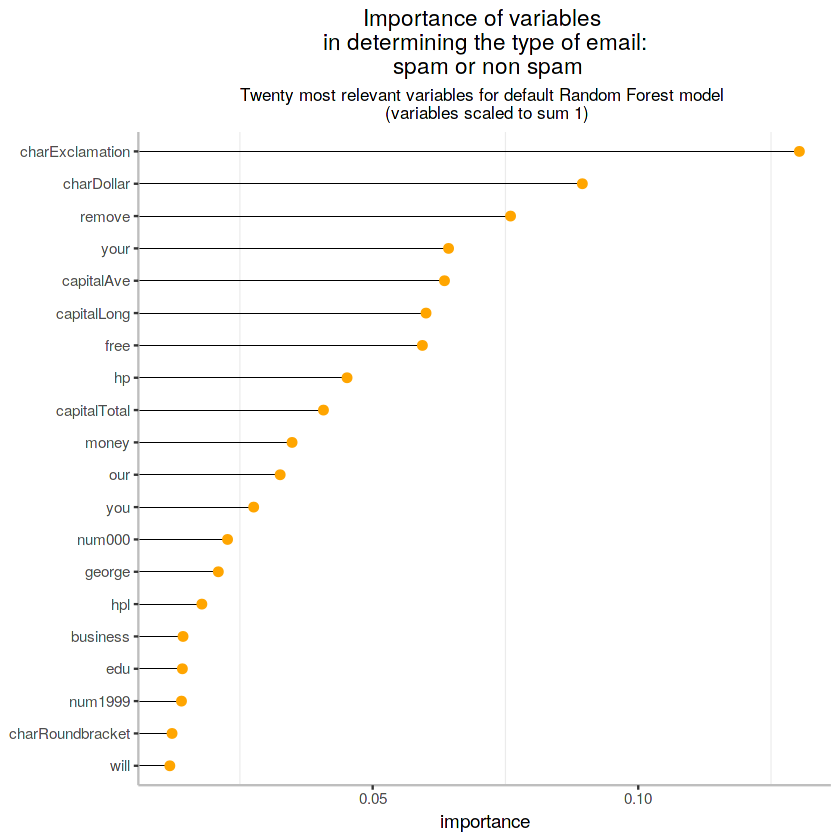

In [95]:
data_frame(variable = imp.def$variable, importance = imp.def$MeanDecreaseGini) %>%
  mutate(importance = importance / sum(importance)) %>%
  top_n(20) %>%
  ggplot(aes(x = importance,
             y = reorder(variable, importance))) +
  labs(title = "Importance of variables \n in determining the type of email: \n spam or non spam",
       subtitle = "Twenty most relevant variables for default Random Forest model \n (variables scaled to sum 1)") +
  theme_bw() +
  theme(axis.title.y = element_blank(),
        plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        axis.line = element_line(colour = "grey"),
        panel.grid.major = element_blank(), panel.border = element_blank()) +
  geom_segment(aes(x = -Inf, y = reorder(variable, importance),
                   xend = importance, yend = reorder(variable, importance)),
               size = 0.2) + 
  geom_point(color = "orange", cex = 2)

### 4.3. Calculate the importance of spam variables for stumps RF

In [84]:
(rf.d1 <- randomForest(type ~ ., data = train, maxnodes = 2))


Call:
 randomForest(formula = type ~ ., data = learn, maxnodes = 2) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 17.17%
Confusion matrix:
        nonspam spam class.error
nonspam    1932   20   0.0102459
spam        533  736   0.4200158

In [86]:
# ?importance
imp.d1 <- as.data.frame(importance(rf.d1))
imp.d1$variable <- rownames(imp.d1)

# See top 20 most important variables
arrange(imp.d1, desc(MeanDecreaseGini))[1:20,]

MeanDecreaseGini,variable
64.301241,charDollar
42.598855,charExclamation
39.150650,remove
32.699291,free
27.944416,capitalAve
27.806511,your
19.930254,money
19.842940,capitalLong
11.904380,num000
11.412404,our


Selecting by importance


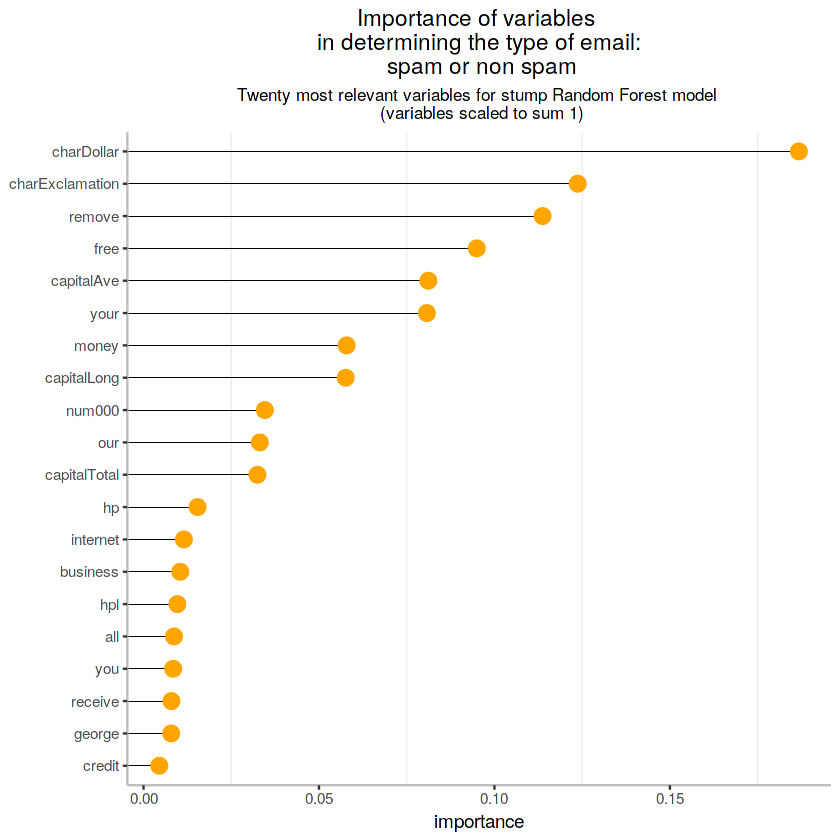

In [94]:
data_frame(variable = imp.d1$variable, importance = imp.d1$MeanDecreaseGini) %>%
  mutate(importance = importance / sum(importance)) %>%
  top_n(20) %>%
  ggplot(aes(x = importance,
             y = reorder(variable, importance))) +
  labs(title = "Importance of variables \n in determining the type of email: \n spam or non spam",
       subtitle = "Twenty most relevant variables for stump Random Forest model \n (variables scaled to sum 1)") +
  theme_bw() +
  theme(axis.title.y = element_blank(),
        plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        axis.line = element_line(colour = "grey"),
        panel.grid.major = element_blank(), panel.border = element_blank()) +
  geom_segment(aes(x = -Inf, y = reorder(variable, importance),
                   xend = importance, yend = reorder(variable, importance)),
               size = 0.2) + 
  geom_point(color = "orange", cex = 2)

### 4.4. Illustrate the influence of the mtry parameter on the OOB error and on the VI

## 5. Variable selection using random forests

### 5.1. Load the library **VSURF**

In [41]:
# Load library
library(VSURF)

### 5.2. Apply **VSURF** on a subset of 500 observations of the data table spam.app

In [75]:
# Subset spam data using stratified sampling
spam.app <- 
  spam %>%
      group_by(type) %>%
          sample_n(250)

In [76]:
# Apply VSURF
vsurf.spam <- VSURF(type ~ ., data = spam.app, parallel = TRUE, clusterType = "FORK", ncores = detectCores() - 1)

Warning message in VSURF.formula(type ~ ., data = spam.app, parallel = TRUE, clusterType = "FORK", :
“VSURF with a formula-type call outputs selected variables
which are indices of the input matrix based on the formula:
you may reorder these to get indices of the original data”

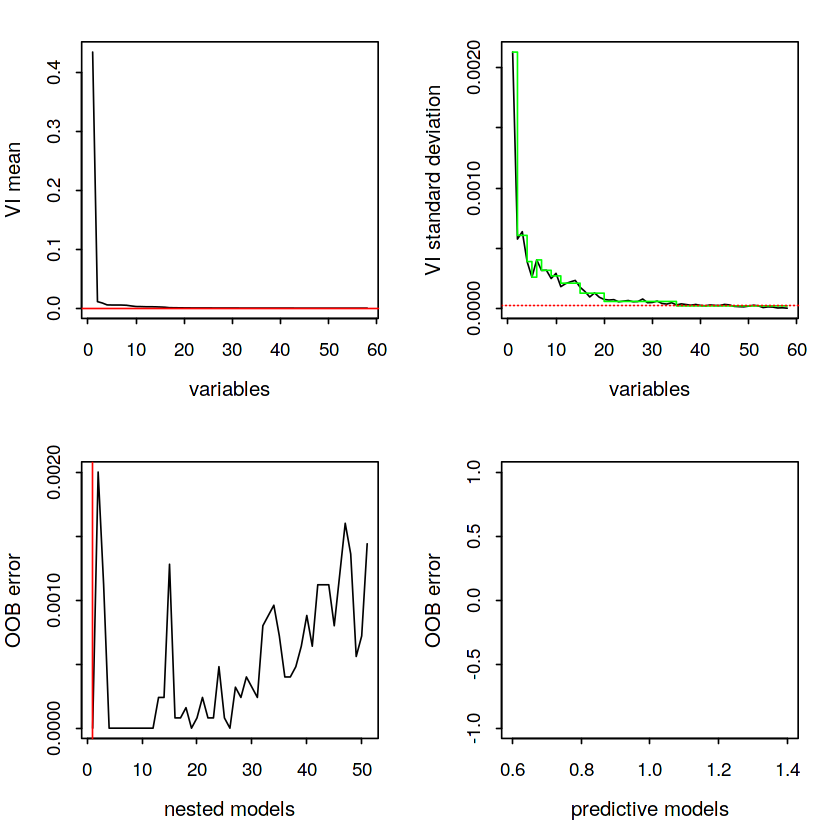

In [77]:
plot(vsurf.spam, cex.axis = 1.1, cex.lab = 1.2)

### 5.3. Comment on the results of the different steps

In [78]:
summary(vsurf.spam)


 VSURF computation time: 1.3 mins 

 VSURF selected: 
	51 variables at thresholding step (in 17.8 secs)
	1 variables at interpretation step (in 57.3 secs)
	1 variables at prediction step (in 0.8 secs)

 VSURF ran in parallel on a FORK cluster and used 7 cores 


In [79]:
# Thresholding variables
colnames(spam.app[vsurf.spam$varselect.thres])

[1] "type"              "hp"                "money"            
 [4] "george"            "remove"            "charDollar"       
 [7] "charExclamation"   "free"              "capitalAve"       
[10] "capitalTotal"      "edu"               "capitalLong"      
[13] "hpl"               "num000"            "your"             
[16] "num1999"           "our"               "you"              
[19] "business"          "over"              "num85"            
[22] "internet"          "will"              "meeting"          
[25] "email"             "num650"            "order"            
[28] "credit"            "lab"               "receive"          
[31] "re"                "telnet"            "labs"             
[34] "charRoundbracket"  "data"              "pm"               
[37] "charSemicolon"     "addresses"         "mail"             
[40] "charSquarebracket" "project"           "charHash"         
[43] "technology"        "original"          "address"          
[46] "all"               "num415"            "num857"           
[49] "cs"                "font"              "people"

In [80]:
# Interpretation variables
colnames(spam.app[vsurf.spam$varselect.interp])

[1] "type"

In [81]:
# Prediction variables
colnames(spam.app[vsurf.spam$varselect.pred])

[1] "type"

#### Stump RF model

In [83]:
vsurf.stump <- VSURF(type ~ ., spam.app, maxnodes = 2, parallel = TRUE, clusterType = "FORK", ncores = detectCores() - 1)

Warning message in VSURF.formula(type ~ ., spam.app, maxnodes = 2, parallel = TRUE, :
“VSURF with a formula-type call outputs selected variables
which are indices of the input matrix based on the formula:
you may reorder these to get indices of the original data”

In [88]:
# Print summary
summary(vsurf.stump)


 VSURF computation time: 40.6 secs 

 VSURF selected: 
	58 variables at thresholding step (in 8.5 secs)
	1 variables at interpretation step (in 31.6 secs)
	1 variables at prediction step (in 0.5 secs)

 VSURF ran in parallel on a FORK cluster and used 7 cores 


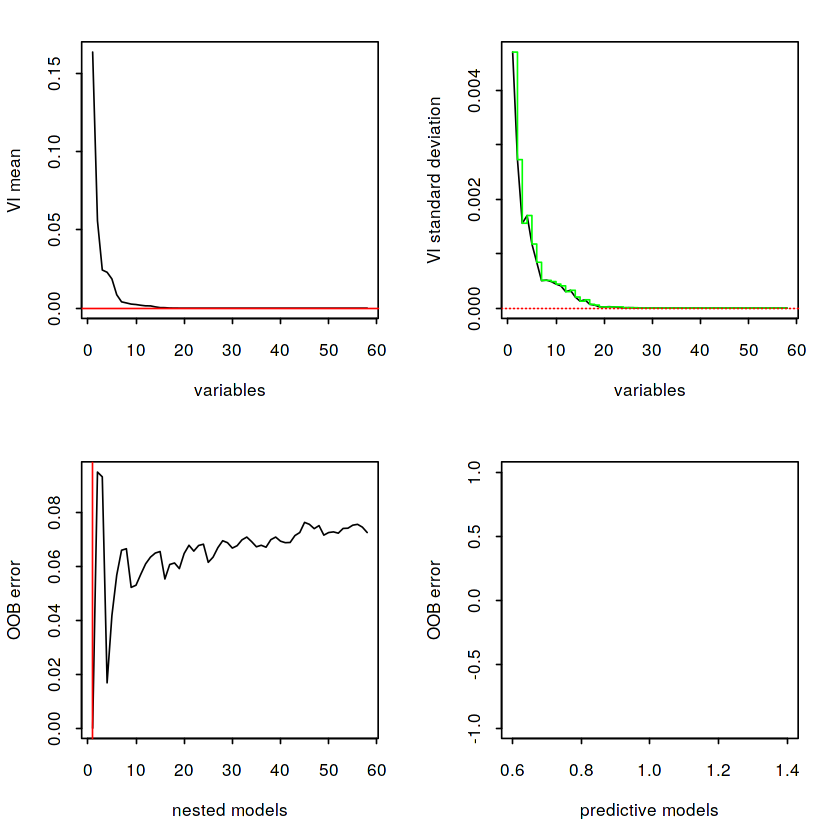

In [97]:
# Plot
plot(vsurf.stump)

### 5.4. Experiment with the parallel version based on the article on **VSURF**

In [109]:
# Try different thresholds values (tuning the function)

# Number of forest to grown values for each step (from 10 to 100)
nfor.thres.values <- seq(0, 100, by = 10)[-1]
nfor.interp.values <- seq(0, 100, by = 10)[-1]
nfor.pred.values <- seq(0, 100, by = 10)[-1]

# All combinations for the different nfor values in each step
list.nfor.thres <- lapply(nfor.thres.values, function(x) {
    message(paste0("\n Calculating VSURF with nfor.thres = ", x))
    VSURF(type ~ ., data = spam.app, nfor.thres = x, parallel = TRUE, clusterType = "PSOCK", ncores = detectCores() - 1)
})

Calculating VSURF with nfor.thres = 10
Warning message in VSURF.formula(type ~ ., data = spam.app, nfor.thres = x, parallel = TRUE, :
“VSURF with a formula-type call outputs selected variables
which are indices of the input matrix based on the formula:
you may reorder these to get indices of the original data”Calculating VSURF with nfor.thres = 20
Warning message in VSURF.formula(type ~ ., data = spam.app, nfor.thres = x, parallel = TRUE, :
“VSURF with a formula-type call outputs selected variables
which are indices of the input matrix based on the formula:
you may reorder these to get indices of the original data”Calculating VSURF with nfor.thres = 30
Warning message in VSURF.formula(type ~ ., data = spam.app, nfor.thres = x, parallel = TRUE, :
“VSURF with a formula-type call outputs selected variables
which are indices of the input matrix based on the formula:
you may reorder these to get indices of the original data”Calculating VSURF with nfor.thres = 40
Warning message in VSURF.for

In [118]:

number.threshold.vars <- lapply(1:9, function(x) {
    message(paste0("\n Getting number of threshold variables for "), nfor.thres.values[x])
    length(list.nfor.thres[[x]]$varselect.thres)
})

number.threshold.vars


 Getting number of threshold variables for 10

 Getting number of threshold variables for 20

 Getting number of threshold variables for 30

 Getting number of threshold variables for 40

 Getting number of threshold variables for 50

 Getting number of threshold variables for 60

 Getting number of threshold variables for 70

 Getting number of threshold variables for 80

 Getting number of threshold variables for 90


[[1]]
[1] 49

[[2]]
[1] 51

[[3]]
[1] 51

[[4]]
[1] 54

[[5]]
[1] 54

[[6]]
[1] 56

[[7]]
[1] 53

[[8]]
[1] 54

[[9]]
[1] 53

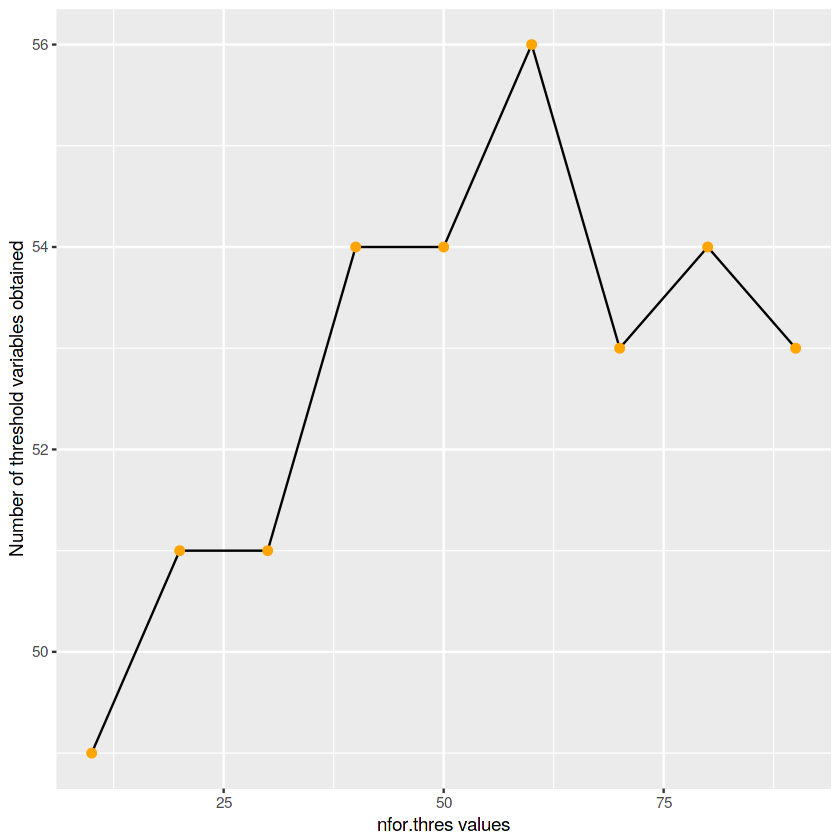

In [139]:
# Make a plot with number of thresholds variables vs number of forest threshold (nfor.thres)
ggplot()  + 
  geom_line(aes(x = nfor.thres.values[-10], y = unlist(number.threshold.vars))) + 
  geom_point(aes(x = nfor.thres.values[-10], y = unlist(number.threshold.vars)), color = "orange", cex = 2) + 
  labs(x = "nfor.thres values", y = "Number of threshold variables obtained")


In [122]:
# Para cada combinación hacer un plot que muestre el número de threshold variables, interpretation variables and predicted variables
# Buscar las variables que se repiten 

ERROR: Error in parse(text = x, srcfile = src): <text>:8:0: unexpected end of input
6: # Para cada combinación hacer un plot que muestre el número de threshold variables, interpretation variables and predicted variables
7: # Buscar las variables que se repiten 
  ^


In [96]:
?VSURF

VSURF {VSURF},R Documentation
"x, formula","A data frame or a matrix of predictors, the columns represent the variables. Or a formula describing the model to be fitted."
...,others parameters to be passed on to the randomForest function (see ?randomForest for further information).
y,A response vector (must be a factor for classification problems and numeric for regression ones).
ntree,Number of trees in each forests grown. Standard parameter of randomForest.
mtry,Number of variables randomly sampled as candidates at each split. Standard parameter of randomForest.
nfor.thres,"Number of forests grown for ""thresholding step"" (first of the three steps)."
nmin,"Number of times the ""minimum value"" is multiplied to set threshold value."
nfor.interp,"Number of forests grown for ""intepretation step"" (second of the three steps)."
nsd,Number of times the standard deviation of the minimum value of err.interp is multiplied.
nfor.pred,"Number of forests grown for ""prediction step"" (last of the three steps)."


In [ ]:
# Make a combination of diferent thresholds and create a raster view 